In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
print("sklearn version:", sklearn.__version__)

sklearn version: 0.18.1


In [2]:
reviews = pd.read_csv("reviews.csv")
print(reviews.shape)
print(reviews.info())

(13442, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13442 entries, 0 to 13441
Data columns (total 9 columns):
critic         12737 non-null object
fresh          13442 non-null object
imdb           13442 non-null int64
link           13442 non-null object
publication    13442 non-null object
quote          13442 non-null object
review_date    13442 non-null object
rtid           13442 non-null int64
title          13442 non-null object
dtypes: int64(2), object(7)
memory usage: 945.2+ KB
None


In [3]:
reviews.head()

,critic,fresh,imdb,link,publication,quote,review_date,rtid,title
0,Derek Adams,fresh,114709,http://www.timeout.com/film/reviews/87745/toy-...,Time Out,"So ingenious in concept, design and execution ...",2009-10-04 00:00:00,9559,Toy Story
1,Richard Corliss,fresh,114709,"http://www.time.com/time/magazine/article/0,91...",TIME Magazine,The year's most inventive comedy.,2008-08-31 00:00:00,9559,Toy Story
2,David Ansen,fresh,114709,http://www.newsweek.com/id/104199,Newsweek,A winning animated feature that has something ...,2008-08-18 00:00:00,9559,Toy Story
3,Leonard Klady,fresh,114709,http://www.variety.com/review/VE1117941294.htm...,Variety,The film sports a provocative and appealing st...,2008-06-09 00:00:00,9559,Toy Story
4,Jonathan Rosenbaum,fresh,114709,http://onfilm.chicagoreader.com/movies/capsule...,Chicago Reader,"An entertaining computer-generated, hyperreali...",2008-03-10 00:00:00,9559,Toy Story


### Descriptive Analysis

#### Number of reviews per reviewer

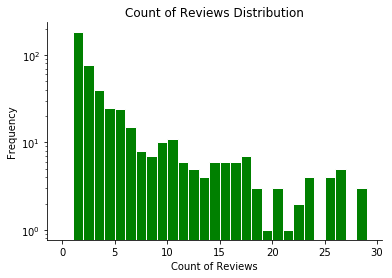

In [4]:
review_by_critic = reviews.groupby(['critic']).aggregate('count')# group by critics and count the reviews per group
plt.figure()
plt.hist(review_by_critic['rtid'], color="green", edgecolor="white", bins=range(0,30), log=True) # plot the histogram of log counts per critic
plt.xlabel("Count of Reviews")
plt.ylabel("Frequency")
plt.title("Count of Reviews Distribution")
# set spines
ax = plt.gca()
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
plt.show()

#### Top fresh and rotton movies

In [5]:
review_by_title = reviews.groupby(['fresh', 'title']).aggregate('count').reset_index()
top_fresh_title = review_by_title[review_by_title['fresh']=='fresh'].sort_values(by='rtid', ascending=False)
print("Top 10 fresh movies:")
top_fresh_title[:10]['title']

Top 10 fresh movies:


378                                 Face/Off
1433                               Toy Story
613                                   Kinsey
498                                   Hamlet
610                                King Kong
444                             Galaxy Quest
164                                      Big
511                       Heavenly Creatures
969     Seven Samurai (Shichinin no Samurai)
145                     Beauty and the Beast
Name: title, dtype: object

In [6]:
top_rotton_title = review_by_title[review_by_title['fresh']=='rotten'].sort_values(by='rtid', ascending=False)
print("Top 10 rotton movies:")
top_rotton_title[:10]['title']

Top 10 rotton movies:


2783                 The Time Traveler's Wife
2342                          Problem Child 2
2749                       The Scarlet Letter
2797                                The Women
1675                         Basic Instinct 2
2700    The Mummy: Tomb of the Dragon Emperor
2348                       Punisher: War Zone
1957                             Georgia Rule
2318                           Pink Panther 2
2359                            Random Hearts
Name: title, dtype: object

### Naive Bayes Classifier

Using the `reviews` dataframe, compute a pair of numerical X, Y arrays where:
    
 * X is a `(nreview, nwords)` array. Each row corresponds to a bag-of-words representation for a single review. 
 * Y is a `nreview`-element 1/0 array, encoding whether a review is Fresh (1) or Rotten (0). This is the desired *output*.

In [16]:
"""
Function
--------
make_xy

Build a bag-of-words training set for the review data

Parameters
-----------
reviews : Pandas DataFrame
    The review data from above
    
vectorizer : CountVectorizer object (optional)
    A CountVectorizer object to use. If None,
    then create and fit a new CountVectorizer.
    Otherwise, re-fit the provided CountVectorizer
    using the reviews data
    
Returns
-------
X : numpy array (dims: nreview, nwords)
    Bag-of-words representation for each review.
Y : numpy array (dims: nreview)
    1/0 array. 1 = fresh review, 0 = rotten review

Examples
--------
X, Y = make_xy(reviews)
"""
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
class vectorize_x(BaseEstimator, TransformerMixin):
    def __init__(self, min_df=1):
        self.vectorizer = CountVectorizer(min_df=min_df)
    def fit(self, X, y=None):
        return self # nothing to do
    def transform(self, X, y=None):
        X = self.vectorizer.fit_transform(X)
        X = X.toarray()
        return X

In [17]:
X = vectorize_x().transform(reviews['quote'])
y = np.array([1 if reviews["fresh"].iloc[i]=="fresh" else 0 for i in range(len(reviews["fresh"]))])

In [18]:
print(X.shape, y.shape)

(13442, 20890) (13442,)


### Split data and Train a Naive Bayes Classifier

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape)

(9006, 20890) (4436, 20890)


In [20]:
from sklearn.naive_bayes import MultinomialNB
MultiNB = MultinomialNB()
MultiNB.fit(X_train, y_train)
print("Accurarcy of Train:\n", MultiNB.score(X_train, y_train)) # prediction of train
print("Accurarcy of Test:\n", MultiNB.score(X_test, y_test)) # prediction of test

Accurarcy of Train:
 0.923051299134
Accurarcy of Test:
 0.786519386835


The model is obvisouly overfitting

### Optimization and Cross-Validation

In [24]:
from sklearn.model_selection import cross_val_score
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
accuracy = 0.0
for alpha in alphas:
    for min_df in min_dfs:
        X = vectorize_x(min_df).transform(reviews['quote'])
        fitted_model = MultinomialNB(alpha=alpha)
        this_score = cross_val_score(fitted_model, X, y, cv=5).mean()
        print("alpha:{}, min_df:{}, accuracy:{}".format(alpha, min_df, this_score))
        if this_score > accuracy: # find the maximum log likelihood
            best_alpha = alpha
            best_min_df = min_df
            accuracy = this_score
print("\nbest alpha:{}, best min_df:{}, max accuracy:{}".format(best_alpha, best_min_df, accuracy))

C:\Users\yaozh\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\yaozh\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\yaozh\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\yaozh\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\yaozh\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


alpha:0, min_df:1e-05, accuracy:0.3759113061969779


C:\Users\yaozh\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\yaozh\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\yaozh\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\yaozh\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\yaozh\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


alpha:0, min_df:0.0001, accuracy:0.3759113061969779


C:\Users\yaozh\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\yaozh\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\yaozh\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\yaozh\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -
C:\Users\yaozh\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:699: RuntimeWarning: divide by zero encountered in log
  self.feature_log_prob_ = (np.log(smoothed_fc) -


alpha:0, min_df:0.001, accuracy:0.3759113061969779
alpha:0, min_df:0.01, accuracy:0.6614339373400023
alpha:0, min_df:0.1, accuracy:0.625279253230196
alpha:0.1, min_df:1e-05, accuracy:0.7457967118534982
alpha:0.1, min_df:0.0001, accuracy:0.7463176836606498
alpha:0.1, min_df:0.001, accuracy:0.7385066773078157
alpha:0.1, min_df:0.01, accuracy:0.6612107230336924
alpha:0.1, min_df:0.1, accuracy:0.625279253230196
alpha:1, min_df:1e-05, accuracy:0.7699002865306385
alpha:1, min_df:0.0001, accuracy:0.7691566264570416
alpha:1, min_df:0.001, accuracy:0.7408870486383335
alpha:1, min_df:0.01, accuracy:0.6618803382825729
alpha:1, min_df:0.1, accuracy:0.6252048484682912
alpha:5, min_df:1e-05, accuracy:0.6819673561032065
alpha:5, min_df:0.0001, accuracy:0.7278675979012511
alpha:5, min_df:0.001, accuracy:0.739175683321325
alpha:5, min_df:0.01, accuracy:0.6624755487489528
alpha:5, min_df:0.1, accuracy:0.6249817172133195
alpha:10, min_df:1e-05, accuracy:0.6441013624901861
alpha:10, min_df:0.0001, accurac